# Sentiment Analysis of Tweets with Coronavirus/ Covid19 Hashtags

#### Note:
We compute the polarity (and normalized polarity) of tweets containing the hashtags *Coronavirus* and/or *Covid19*.
Polarity will be based on vader's polarity scores.
Additionally, we investigate the polarity of tweets with a reference to asian ethnic groups.

Tweet texts will be cleaned by setting all characters to lowercase and removing words with backslash x, stopwords, links, and special characters using simple regex statements. 

The result will be stored in DataFrame *tweets_df* with the following columns:
- timestamp
- tweet_text
- username
- all_hashtags
- followers_count
- location
- clean_text
- polarity
- normalized_polarity

In [508]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


### Import needed files and libraries:

In [509]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

[nltk_data] Downloading package stopwords to /Users/april/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [510]:
# Importing vader lexicon 
vader_lex = pd.read_csv('vader_lexicon.txt', 
                   sep='\t',
                   usecols=[0, 1], 
                   names=['token', 'polarity'],
                   index_col='token')

# Setting stopwords
stop_words = list(set(stopwords.words('english')))

In [511]:
# Importing tweets
csv_file = 'hashtagcoronavirus_covid19.csv'
column_name = 'tweet_text'

# Initializing DataFrame tweets_df
tweets_df = pd.read_csv(csv_file)
tweet_text = tweets_df.loc[:, (column_name)]

### Clean data and compute both normalized and non-normalized polarity:

In [512]:
def clean_tweet(tweet): 
    '''
    1. Lowercase text
    2. Remove words with backslash x
    2. Clean tweet text by removing links, special characters using simple regex statements. 
    3. Remove stopwords
    '''

    low = tweet.lower()
    low_fil = " ".join(filter(lambda x:x[:2]!='\\x', low.split()))
    no_punct = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", low_fil).split())
    cleaned = " ".join(filter(lambda x:x not in stop_words, no_punct.split()))
    return cleaned
    

In [513]:
# To compute normalized polarity

def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # object gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    return sentiment_dict['compound']

In [514]:
# Terms that refer to asian ethnic groups
asian_ref = ['asian', 'chinese', 'china', 'wuhan']

# Creating new column with cleaned tweet texts
for i in range(len(tweet_text)):
    cleaned = clean_tweet(tweet_text[i][1:])
    tweets_df.at[i, "clean_text"] = cleaned
    
    # Selecting tweets with any reference to asian ethnic groups:
    if (pd.Series(cleaned.split()).isin(asian_ref).any()):
        tweets_df.at[i, "asian_ref"] = 1
    else:
        tweets_df.at[i, "asian_ref"] = 0
    # Computing normalized polarity using vader's sentiment_scores function
    tweets_df.at[i, "normalized_polarity"] = sentiment_scores(cleaned)

##### Computing non-normalized polarity:

In [515]:
# Converting tweets into tidy_format
tidy_format = (tweets_df["clean_text"].str.split(expand=True).stack().reset_index(level=1).rename(columns={'level_1': 'num', 0: 'word'}))


In [516]:
# Computing polarity of each tweet text by summing polarity of each word in text
# Polarity of each word based on vader's polarity in vader_lexicon.txt 
tweets_df['polarity'] = tidy_format.merge(vader_lex, how='left', left_on='word', right_index=True).reset_index().loc[:, ['index', 'polarity']].groupby('index').sum().fillna(0)

### Result:

#### All Tweets:

In [517]:
# Updated tweets DataFrame with additional clean_text, polarity, and normalized_polarity columns
tweets_df

,timestamp,tweet_text,username,all_hashtags,followers_count,location,clean_text,asian_ref,normalized_polarity,polarity
0,2020-04-14 02:31:35,b'He gets up every day? Hasn\xe2\x80\x99t caug...,b'bigmusicfan71',"['coronavirus', 'COVID19', '25thAmendmentNow']",354,b'',gets every day xe2 x80 x99t caught coronavirus...,0.0,0.0000,0.0
1,2020-04-14 02:31:35,b'@Welptheresthat @NorthmanTrader Not when the...,b'GKeeto',"['china', 'ChinaMustExplain', 'ChinaVirus', 'C...",6,b'',product complete chinese made garbage accounts...,1.0,0.0000,0.0
2,2020-04-14 02:31:34,b'Holy \xf0\x9f\x92\xa9 \xe2\x81\xa6@VanityFai...,b'DrumpfsLies',"['INCOMPETENCEKILLS', 'COVID19', 'coronavirus'...",230,"b'California, USA'",holy scorchingly amazing incompetencekills cov...,0.0,0.5859,2.8
3,2020-04-14 02:31:32,b'This could be the end of the line for cruise...,b'1petermartin',"['COVID19', 'coronavirus', 'ausecon', 'auspol']",32382,b'',could end line cruise ships covid19 coronaviru...,0.0,0.0000,0.0
4,2020-04-14 02:31:22,"b'Dear @CNN, Can you sincerely claim @realDon...",b'WarmMonkey',"['coronavirus', 'COVID19']",651,b'Out of The Closet',dear sincerely claim handling coronavirus cris...,0.0,0.6584,1.3
...,...,...,...,...,...,...,...,...,...,...
995,2020-04-14 01:34:17,b'@JimWTAE @WTAE And here is a third Smithfiel...,b'realhumanrights',"['Wisconsin', 'Cudahy', 'COVID19', 'coronaviru...",2853,b'Washington DC',third smithfield food plant wisconsin cudahy 2...,0.0,0.5574,2.6
996,2020-04-14 01:34:15,b'#TruthBeTold Abso-fucking-lutly!!! #Heartb...,b'AltBadDude',"['TruthBeTold', 'Heartbreaking', 'trumpsameric...",1308,"b'Maryland, USA'",truthbetold abso fucking lutly heartbreaking l...,0.0,-0.5829,-2.5
997,2020-04-14 01:34:15,b'Trump assembles his crew of X-Men to save us...,b'BoneKnightmare',"['EndOfDays', 'apocalypse2020', 'COVID19', 'co...",3760,b'Parts Unknown',trump assembles crew x men save us doomed endo...,0.0,-0.2500,-1.0
998,2020-04-14 01:34:14,"b'A shameful incident of Jaunpur, this is how ...",b'itemads',"['CoronaVirus', 'CoronaVirusPandemic', 'Corona...",63,b'Jeddah',shameful incident jaunpur misuse power happens...,0.0,-0.4939,-2.2


In [529]:
max(tweets_df['polarity'])

10.600000000000001

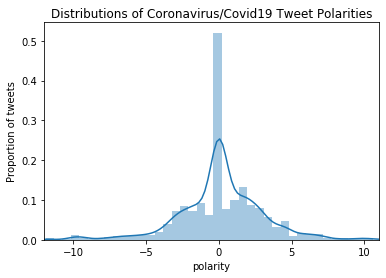

In [533]:
sns.distplot(tweets_df['polarity'])
plt.title('Distributions of Coronavirus/Covid19 Tweet Polarities')
plt.ylabel("Proportion of tweets")
plt.xlim(-12,11);

#### Tweets with asian reference:

In [532]:
asian_ref_tweets = tweets_df.loc[tweets_df['asian_ref'] == 1.0]

71


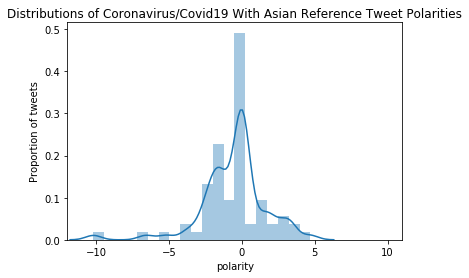

In [534]:
sns.distplot(asian_ref_tweets['polarity'])
plt.title('Distributions of Coronavirus/Covid19 With Asian Reference Tweet Polarities')
plt.ylabel("Proportion of tweets")
plt.xlim(-12,11);